<a href="https://colab.research.google.com/github/chrisseiler96/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/Copy_of_LS_DS1_233_Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [0]:
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [18]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [19]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


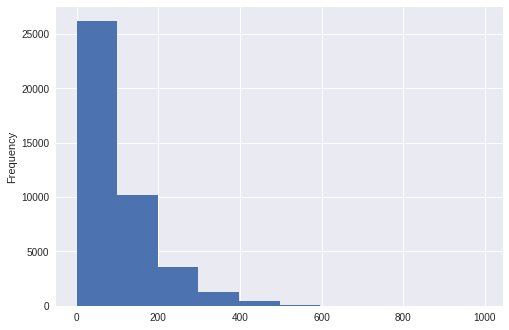

In [20]:
df['pm2.5'].plot.hist();

In [21]:
import numpy as np
df['pm2.5'].dropna().apply(np.log).plot.hist();

ValueError: ignored

In [22]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('pm2.5', axis='columns')
y = df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2590006399659215

In [23]:
','.join(['1', '2', '3'])
# import csv

'1,2,3'

In [24]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# They can also support * for interaction terms and polynomials
# y ~ x1 + (x1 * x1) + x2 + (x1 * x2)
# Also, these formulas break with . in variable name, so lets change that
df = df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()  # "summary" is another very R-thing

pm25 ~ No + year + month + day + hour + DEWP + TEMP + PRES + Iws + Is + Ir


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.1600
Model:                       QuantReg   Bandwidth:                       8.276
Method:                 Least Squares   Sparsity:                        133.8
Date:                Wed, 23 Jan 2019   No. Observations:                41757
Time:                        23:55:37   Df Residuals:                    41745
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004   1.67e-05     22.881      0.000       0.000       0.000
No           3.63e-07   2.67e-05      0.014      0.989    -5.2e-05    5.27e-05
year           0.8830      0.031     28.631      0.000       0.823       0.943
month         -1.4110      0.103    -13.749      0.000      -1.612      -1.210
day            0.4461      0.037     11.951      0.000       0.373       0.519
hour           1.2810      0.050     25.779      0.000       1.184       1.378
DEWP           3.6362      0.047     77.315      0.000       3.544       3.728
TEMP          -4.7103      0.060    -78.779      0.000      -4.828      -4.593
PRES          -1.6265      0.061    -26.760      0.000      -1.746      -1.507
Iws           -0.1541      0.007    -21.786      0.000      -0.168      -0.140
Is            -1.6322      0.425     -3.838      0.000      -2.466      -0.799
Ir            -5.3946      0.234    -23.034      0.000      -5.854      -4.936
==============================================================================

The condition number is large, 3.67e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [25]:
help(quant_mod.fit)

Help on method fit in module statsmodels.regression.quantile_regression:

fit(q=0.5, vcov='robust', kernel='epa', bandwidth='hsheather', max_iter=1000, p_tol=1e-06, **kwargs) method of statsmodels.regression.quantile_regression.QuantReg instance
    Solve by Iterative Weighted Least Squares
    
    Parameters
    ----------
    q : float
        Quantile must be between 0 and 1
    vcov : string, method used to calculate the variance-covariance matrix
        of the parameters. Default is ``robust``:
    
        - robust : heteroskedasticity robust standard errors (as suggested
          in Greene 6th edition)
        - iid : iid errors (as in Stata 12)
    
    kernel : string, kernel to use in the kernel density estimation for the
        asymptotic covariance matrix:
    
        - epa: Epanechnikov
        - cos: Cosine
        - gau: Gaussian
        - par: Parzene
    
    bandwidth: string, Bandwidth selection method in kernel density
        estimation for asymptotic covarian

Pretend R code

```
ols1 <- lm(y ~ x1 + x2 + (x1 * x1))
summary(ols1)
```

In [26]:
quantiles = (.05, .96, .1)

for quantile in quantiles:
  print(quant_mod.fit(q=quantile).summary())

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:              0.04130
Model:                       QuantReg   Bandwidth:                       8.908
Method:                 Least Squares   Sparsity:                        120.7
Date:                Wed, 23 Jan 2019   No. Observations:                41757
Time:                        23:55:45   Df Residuals:                    41745
                                        Df Model:                           11
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.072e-05    6.4e-06      4.803      0.000    1.82e-05    4.33e-05
No         -6.994e-05   9.59e-06     -7.292      0.000   -8.87e-05   -5.11e-05
year           0.0998      0.012      8.275      0.000       0.076       0.123
month         -0.4536      0.034    -13.419      0.0

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

In [27]:
quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
quant_mod = smf.quantreg(quant_formula, data=df)
for quantile in range(50, 100):
  quantile /= 100
  quant_reg = quant_mod.fit(q=quantile)
  print((quantile, quant_reg.prsquared))

(0.5, 0.1447879336023583)
(0.51, 0.1453046499109799)
(0.52, 0.1457984456251047)
(0.53, 0.14627848333343263)
(0.54, 0.1467640446791706)
(0.55, 0.14733094668790292)
(0.56, 0.14787821797693512)
(0.57, 0.14840185621049273)
(0.58, 0.14892138273908107)
(0.59, 0.14946793972061212)


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.6, 0.1500450836285967)
(0.61, 0.15066665485612274)
(0.62, 0.15131550520931825)
(0.63, 0.15201598245712966)
(0.64, 0.152815632180745)
(0.65, 0.15360133883660188)
(0.66, 0.15440046026580068)
(0.67, 0.15521251759239985)
(0.68, 0.15607615678951559)
(0.69, 0.15692695615298136)
(0.7, 0.1577663389046554)
(0.71, 0.15865286212994567)
(0.72, 0.15961363441229715)
(0.73, 0.16062991121153458)
(0.74, 0.1617151201897239)
(0.75, 0.16280951619867146)
(0.76, 0.16394259393342125)
(0.77, 0.16517451474458056)
(0.78, 0.1664423443710097)
(0.79, 0.16770815353095714)


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.8, 0.16904227356438506)
(0.81, 0.17037126968955685)
(0.82, 0.17195593122357777)
(0.83, 0.17383892606382623)
(0.84, 0.17599918426382777)
(0.85, 0.17817588507328963)
(0.86, 0.18047434708570964)
(0.87, 0.18274842963575832)
(0.88, 0.1850748927825704)
(0.89, 0.18767194363846373)
(0.9, 0.1899871464061209)
(0.91, 0.19205778885867675)
(0.92, 0.19409258046839573)
(0.93, 0.1960928580149024)
(0.94, 0.1990718585613529)
(0.95, 0.20306510227274233)
(0.96, 0.20828854295993626)
(0.97, 0.21268428179968246)
(0.98, 0.21668870123970496)
(0.99, 0.21742941318156628)


In [28]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
import numpy as np

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.25)
quant_reg.summary()  # "summary" is another very R-thing

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.2292
Model:                       QuantReg   Bandwidth:                      0.1012
Method:                 Least Squares   Sparsity:                        2.806
Date:                Wed, 23 Jan 2019   No. Observations:                41757
Time:                        23:56:40   Df Residuals:                    41751
                                        Df Model:                            5
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2444      0.013    318.116      0.000       4.218       4.271
DEWP           0.0722      0.001     96.780      0.000       0.071       0.074
TEMP          -0.0701      0.001    -83.629      0.000      -0.072      -0.068
Ir            -0.1079      0.004    -29.400      0.000      -0.115      -0.101
hour           0.0215      0.001     23.206      0.000       0.020       0.023
Iws           -0.0040      0.000    -36.706      0.000      -0.004      -0.004
==============================================================================
"""

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

Live - let's consider another dataset! Specifically, "SkillCraft" (data on competitive StarCraft players): http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

In [29]:
# TODO Live!
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away

import pandas as pd

df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00272/SkillCraft1_Dataset.csv')
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [30]:
df.shape

(3395, 20)

In [31]:
df.isna().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [32]:
import numpy as np
df = df.replace('?', np.nan)
df.isna().sum()

GameID                   0
LeagueIndex              0
Age                     55
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

In [0]:
# Quinn's cleaning code
hasna = ['Age', 'HoursPerWeek', 'TotalHours']

for feat in hasna:
   df[feat] = pd.to_numeric(df[feat])
#df[hasna].head()

In [34]:
df.describe()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3395.000000,3395.000000,3340.000000,3339.000000,3338.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,4805.012371,4.184094,21.647904,15.910752,960.421809,117.046947,0.004299,0.000374,4.364654,0.000098,0.000387,0.003463,40.361562,63.739403,5.272988,22.131664,0.001032,6.534021,0.000059,0.000142
std,2719.944851,1.517327,4.206341,11.962912,17318.133922,51.945291,0.005284,0.000225,2.360333,0.000166,0.000377,0.000992,17.153570,19.238869,1.494835,7.431719,0.000519,1.857697,0.000111,0.000265
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.093600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2464.500000,3.000000,19.000000,8.000000,300.000000,79.900200,0.001258,0.000204,3.000000,0.000000,0.000140,0.002754,28.957750,50.446600,4.272850,17.000000,0.000683,5.000000,0.000000,0.000000
50%,4874.000000,4.000000,21.000000,12.000000,500.000000,108.010200,0.002500,0.000353,4.000000,0.000040,0.000281,0.003395,36.723500,60.931800,5.095500,22.000000,0.000905,6.000000,0.000000,0.000020
75%,7108.500000,5.000000,24.000000,20.000000,800.000000,142.790400,0.005133,0.000499,6.000000,0.000119,0.000514,0.004027,48.290500,73.681300,6.033600,27.000000,0.001259,8.000000,0.000086,0.000181
max,10095.000000,8.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001752,10.000000,0.003019,0.004041,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


In [35]:
df.dtypes

GameID                    int64
LeagueIndex               int64
Age                     float64
HoursPerWeek            float64
TotalHours              float64
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [36]:
# How does linear regression handle it? Courtesy of Daniel
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('APM', axis='columns')
y = df['APM']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.9727919594327304

In [37]:
for name, coef in zip(X.columns, linear_reg.coef_):
  print(name, coef)

GameID 5.6721525875017124e-05
LeagueIndex -0.17025706089711906
Age -0.1255396800327562
HoursPerWeek -0.007084891488397346
TotalHours 6.181852927507429e-06
SelectByHotkeys 5530.168863103678
AssignToHotkeys -948.4647097091305
UniqueHotkeys 0.13583102775973996
MinimapAttacks 2972.11713661456
MinimapRightClicks 4053.6799567315898
NumberOfPACs 23408.13583534949
GapBetweenPACs -0.013256821980193232
ActionLatency -0.17291643312034718
ActionsInPAC 12.798743815559357
TotalMapExplored 0.01939336984054402
WorkersMade 2699.774992506199
UniqueUnitsMade -0.3208898754951155
ComplexUnitsMade 1538.092153791031
ComplexAbilitiesUsed -3127.832963745431


In [38]:
df.LeagueIndex.value_counts()

4    811
5    804
6    621
3    553
2    347
1    167
7     35
Name: LeagueIndex, dtype: int64

In [39]:
# Let's say we want to answer "What are the fastest 10% of SC players like?"
# That means quantile regression with q=0.9

# First we need a formula, with our friend twiddle
quant_formula = 'APM ~ ' + ' + '.join(df.drop('APM', axis='columns').columns)

# From Daniel
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.9)
quant_reg.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    APM   Pseudo R-squared:               0.4076
Model:                       QuantReg   Bandwidth:                       6.911
Method:                 Least Squares   Sparsity:                        179.3
Date:                Wed, 23 Jan 2019   No. Observations:                 3338
Time:                        23:56:43   Df Residuals:                     3318
                                        Df Model:                           19
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1786     22.328      0.008      0.994     -43.599      43.956
GameID                   0.0016      0.000      4.316      0.000       0.001       0.002
LeagueIndex             13.8712      1.115     12.443      0.000      11.685      16.057
Age                      0.5439      0.242      2.252      0.024       0.070       1.017
HoursPerWeek             0.6801      0.072      9.432      0.000       0.539       0.821
TotalHours            7.858e-05   2.16e-05      3.645      0.000    3.63e-05       0.000
SelectByHotkeys          0.0433    564.600   7.67e-05      1.000   -1106.956    1107.042
AssignToHotkeys       8.993e-05    153.980   5.84e-07      1.000    -301.906     301.906
UniqueHotkeys            3.5928      0.461      7.801      0.000       2.690       4.496
MinimapAttacks           0.0001    229.321   5.63e-07      1.000    -449.624     449.625
MinimapRightClicks       0.0027   2886.156   9.21e-07      1.000   -5658.823    5658.828
NumberOfPACs            -0.0021   3483.391  -5.96e-07      1.000   -6829.815    6829.811
GapBetweenPACs           0.2392      0.078      3.060      0.002       0.086       0.393
ActionLatency           -0.8386      0.160     -5.225      0.000      -1.153      -0.524
ActionsInPAC            15.1596      0.938     16.164      0.000      13.321      16.998
TotalMapExplored         0.8265      0.162      5.109      0.000       0.509       1.144
WorkersMade              0.0006   1991.420   3.05e-07      1.000   -3904.535    3904.536
UniqueUnitsMade         -1.3534      0.633     -2.139      0.033      -2.594      -0.113
ComplexUnitsMade        -0.0002     72.101     -3e-06      1.000    -141.368     141.367
ComplexAbilitiesUsed -2.925e-05     61.714  -4.74e-07      1.000    -121.002     121.001
========================================================================================

The condition number is large, 2.16e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
quant_reg.predict(X)[:10]

0    177.075309
1    160.902179
2    112.099983
3    112.118587
4    175.772822
5     41.477271
6     66.971310
7    253.629747
8    122.742125
9    186.566630
dtype: float64

In [41]:
linear_reg.predict(X)[:10]

array([143.63118811, 130.48864924,  67.69761065, 101.45031334,
       130.15490286,  35.98091498,  41.51357034, 208.30622773,
       132.06158302, 144.13021461])

In [42]:
df.TotalHours.value_counts()

500.0        328
400.0        213
1000.0       210
300.0        202
600.0        187
800.0        186
700.0        170
200.0        168
730.0        123
100.0        116
450.0         97
250.0         85
150.0         73
900.0         71
750.0         70
350.0         66
1500.0        58
2000.0        55
650.0         47
1200.0        46
50.0          45
1260.0        28
120.0         26
550.0         23
850.0         22
1100.0        22
80.0          20
1400.0        18
60.0          18
30.0          17
            ... 
315.0          1
980.0          1
1000000.0      1
1466.0         1
711.0          1
425.0          1
153.0          1
477.0          1
9000.0         1
25000.0        1
2800.0         1
410.0          1
310.0          1
275.0          1
1870.0         1
865.0          1
18000.0        1
731.0          1
1098.0         1
770.0          1
460.0          1
3257.0         1
255.0          1
95.0           1
553.0          1
174.0          1
138.0          1
364.0         

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [43]:
import pandas as pd
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [44]:
bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


In [45]:
# TODO - your work here! Also, add text cells for written questions


bwt_df.isna().sum()

bwt          0
gestation    0
parity       0
age          0
height       0
weight       0
smoke        0
dtype: int64

In [46]:
bwt_df.dtypes

bwt          int64
gestation    int64
parity       int64
age          int64
height       int64
weight       int64
smoke        int64
dtype: object

In [47]:
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values

X = bwt_df.drop('bwt', axis='columns')
y = bwt_df['bwt']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2579534937842991

In [48]:
for name, coef in zip(X.columns, linear_reg.coef_):
  print(name, coef)

gestation 0.4439783392634531
parity -3.327199613351645
age -0.008950305361154154
height 1.1540203642500357
weight 0.05016502707680326
smoke -8.40073348432133


In [54]:
bwt_df.bwt.quantile(.055)

90.0

In [55]:
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)

# From Daniel
quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.055)
quant_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2001
Model:                       QuantReg   Bandwidth:                       6.255
Method:                 Least Squares   Sparsity:                        132.8
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        23:59:19   Df Residuals:                     1167
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -96.3832     32.007     -3.011      0.003    -159.182     -33.585
gestation      0.4806      0.089      5.412      0.000       0.306       0.655
parity        -3.2590      2.347     -1.388      0.165      -7.865       1.347
age           -0.0882      0.170     -0.517      0.605      -0.423       0.246
height         1.2257      0.437      2.807      0.005       0.369       2.082
weight        -0.1193      0.057     -2.099      0.036      -0.231      -0.008
smoke         -8.6951      1.867     -4.656      0.000     -12.359      -5.031
==============================================================================

The condition number is large, 9.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


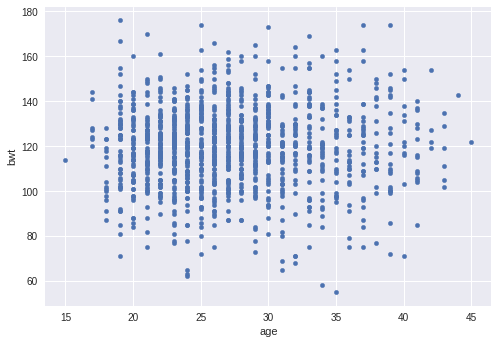

In [7]:
bwt_df.plot.scatter(x='age', y='bwt')

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model